In [1]:
# data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# load data
df = pd.read_csv('data/processed_review_data.csv')

# Train-test split. 20% test. Stratify on y label
X = df.drop(columns = ['classification'])
y = df[['classification']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

X_test['review_text'] = X_test['review_text'].astype(str)

#flatten y
y_test = y_test.values.ravel()
# encode variables (minority class = 1)
y_test = np.where(y_test=='Negative', 1, 0)

In [2]:
# Load functions defined in 'functions.py'
from functions import lower_case,expandContractions,alpha_num,consec_dup,lemma

# Map functions
for func in [lower_case,expandContractions,alpha_num,consec_dup,lemma]:
    X_test['review_text'] = X_test['review_text'].map(func)

In [3]:
# load trained models
import pickle
nb = pickle.load(open("data/nb_trained.sav", 'rb'))
lr = pickle.load(open("data/lr_trained.sav", 'rb'))
svm = pickle.load(open("data/svm_trained.sav", 'rb'))

In [4]:
nb.fit(X_test['review_text'],y_test)
lr.fit(X_test['review_text'],y_test)
svm.fit(X_test['review_text'],y_test)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('svm', SVC(C=1, kernel='linear', random_state=1))])

F1 Score: 0.9563704884765908


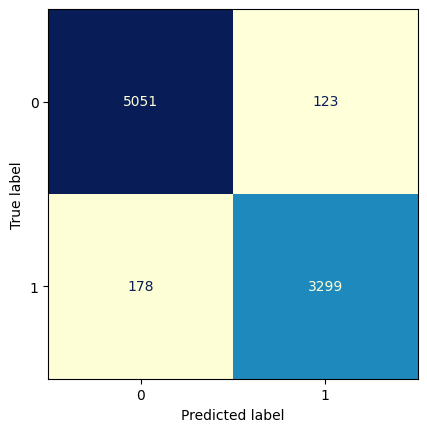

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

nb_pred = nb.predict(X_test['review_text'])
ConfusionMatrixDisplay.from_estimator(nb, X_test['review_text'], 
                                      y_test, 
                                      colorbar = False,
                                      cmap=plt.cm.YlGnBu)

print(f'F1 Score: {f1_score(y_test, nb_pred)}')

F1 Score: 0.9665846955012295


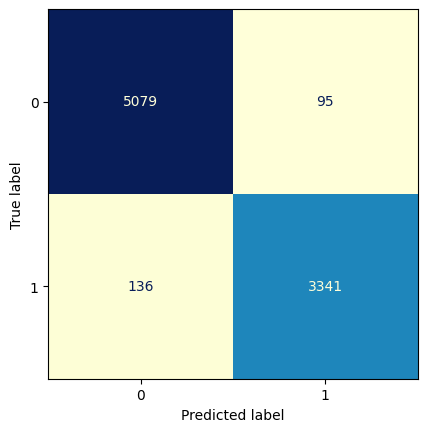

In [6]:
lr_pred = lr.predict(X_test['review_text'])
ConfusionMatrixDisplay.from_estimator(lr, X_test['review_text'], 
                                      y_test, 
                                      colorbar = False,
                                      cmap=plt.cm.YlGnBu)

print(f'F1 Score: {f1_score(y_test, lr_pred)}')

F1 Score: 0.9550854824688496


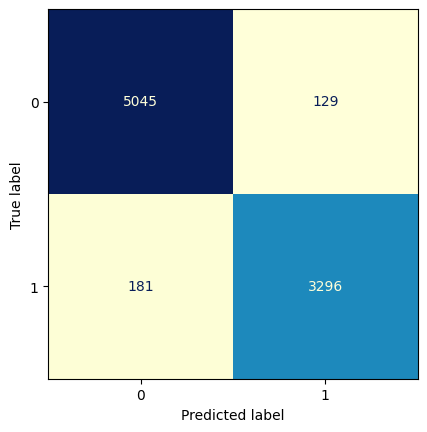

In [7]:
svm_pred = svm.predict(X_test['review_text'])
ConfusionMatrixDisplay.from_estimator(svm, X_test['review_text'], 
                                      y_test, 
                                      colorbar = False,
                                      cmap=plt.cm.YlGnBu)

print(f'F1 Score: {f1_score(y_test, svm_pred)}')

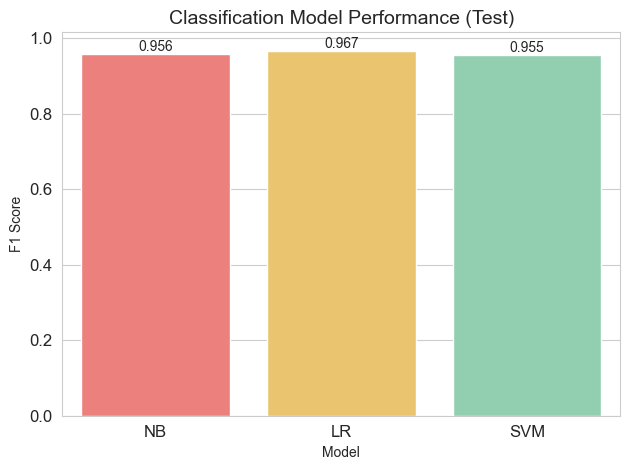

In [8]:
import seaborn as sns

# plot model performance
sns.set_style('whitegrid')
ax = sns.barplot(
    data=pd.DataFrame([['NB', f1_score(y_test, nb_pred)], ['LR', f1_score(y_test, lr_pred)], ['SVM', f1_score(y_test, svm_pred)]],columns=['Model','F1 Score']),
    x="Model",
    y='F1 Score',
    palette=["#FF6F69","#ffcc5c","#88D8B0"])

ax.bar_label(ax.containers[0],fmt='%.3f')
plt.title('Classification Model Performance (Test)',fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

In [9]:
# Load NLP pipeline
import spacy
spacy.require_cpu()
nlp = spacy.load("en_core_web_sm")

# Extract coefficients from model
coefs = lr.named_steps['lr'].coef_.ravel().tolist()

# Extract word list from model
words = lr.named_steps['vect'].get_feature_names_out().tolist()
words = pd.Series(words)

# POS tagging
def pos(text):
    doc = nlp(text)
    text = [token.pos_ for token in doc]
    text = " ".join(text)
    return text
pos = words.map(pos)

# Store as data frame
df1 = pd.DataFrame({
    'POS': pos,
    'Words': words,
    'Coefs': coefs})


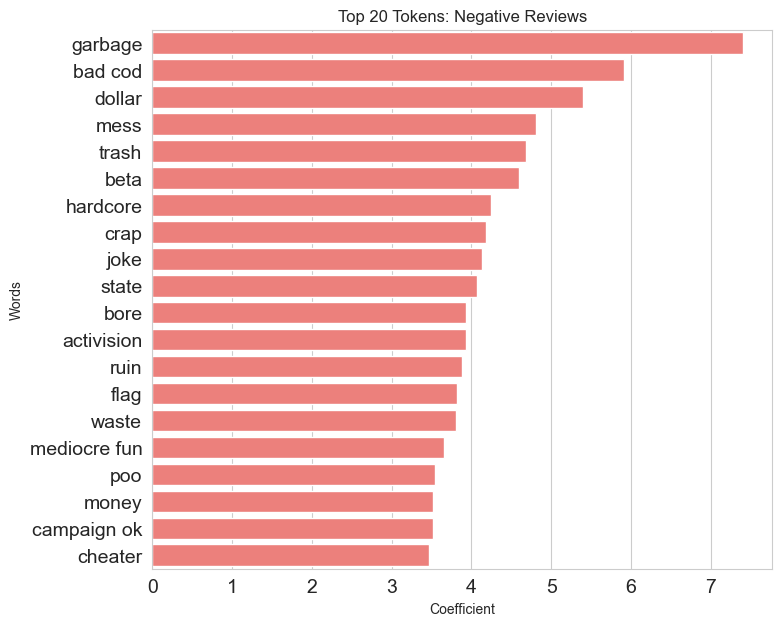

In [10]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,7))
sns.barplot(data = df1[df1['POS'].str.contains("NOUN")].sort_values(by='Coefs',ascending=False,ignore_index=True).head(20),
        y = 'Words',
        x = 'Coefs',
        color="#FF6F69")
        
#ax.invert_yaxis()
ax.tick_params(labelsize=14)
ax.set(title="Top 20 Tokens: Negative Reviews",
       xlabel="Coefficient")

fig.savefig('images/negtokens.png',bbox_inches = "tight");

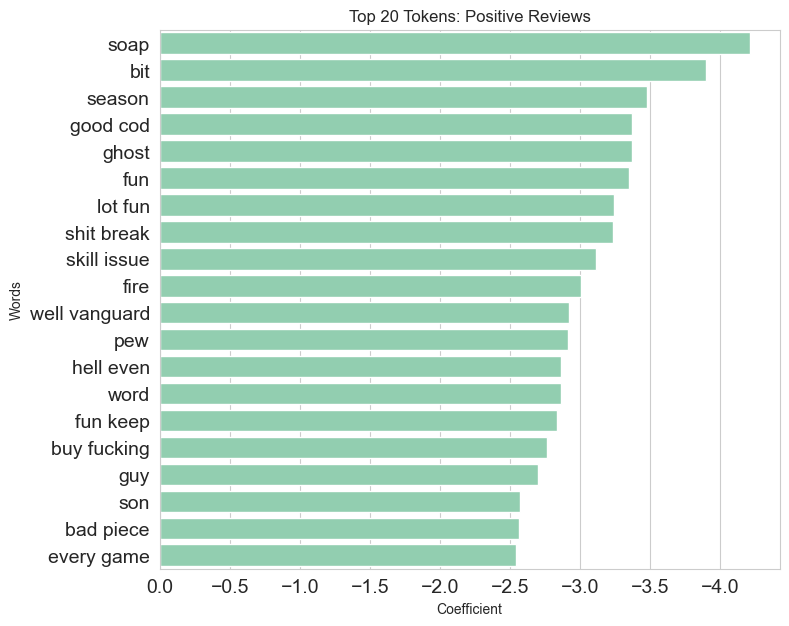

In [11]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,7))
sns.barplot(data = df1[df1['POS'].str.contains("NOUN")].sort_values(by='Coefs',ascending=True,ignore_index=True).head(20),
        y = 'Words',
        x = 'Coefs',
        color="#88D8B0")
        
ax.invert_xaxis()
ax.tick_params(labelsize=14)
ax.set(title="Top 20 Tokens: Positive Reviews",
       xlabel="Coefficient")

fig.savefig('images/postokens.png',bbox_inches = "tight");